In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import chardet
from matplotlib.pyplot import figure

In [92]:
# reading in vacancy_rate.csv taken from the census beauru and taking out the overall vacancy rate
df2 = pd.read_csv("Resources/vacancy_rate.csv", encoding = "ISO-8859-1")
normal_rate = float(df2.loc[3,"San Francisco-Oakland-Berkeley, CA Metro Area!!Percent"].strip("%"))
normal_rate = normal_rate/100

In [93]:
# Reading in listings.csv
listings = pd.read_csv("Resources/listings.csv")
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,958.0,Serviced apartment in San Francisco · ★4.87 · ...,1169,Holly,NaN,Western Addition,37.77028,-122.43317,Entire home/apt,187,2,405,8/7/2023,2.36,1,150,45,City Registration Pending
1,5858.0,Rental unit in San Francisco · ★4.88 · 2 bedro...,8904,Philip And Tania,NaN,Bernal Heights,37.74474,-122.42089,Entire home/apt,235,30,111,8/6/2017,0.64,1,365,0,NaN
2,8142.0,Rental unit in San Francisco · ★4.70 · 1 bedro...,21994,Aaron,NaN,Haight Ashbury,37.76555,-122.45213,Private room,56,32,10,7/30/2023,0.09,15,363,2,NaN
3,8339.0,Condo in San Francisco · ★4.87 · 1 bedroom · 1...,24215,Rosy,NaN,Western Addition,37.77564,-122.43642,Entire home/apt,480,5,28,6/28/2019,0.16,2,365,0,STR-0000264
4,8739.0,Condo in San Francisco · ★4.92 · 1 bedroom · 1...,7149,Ivan & Wendy,NaN,Mission,37.76030,-122.42197,Private room,122,1,792,8/21/2023,4.62,2,148,39,STR-0000028


In [94]:
# Narrow the listings dataset for only specific columns
df = listings[["neighbourhood","latitude","longitude","room_type","price","availability_365"]]
df.head()

,neighbourhood,latitude,longitude,room_type,price,availability_365
0,Western Addition,37.77028,-122.43317,Entire home/apt,187,150
1,Bernal Heights,37.74474,-122.42089,Entire home/apt,235,365
2,Haight Ashbury,37.76555,-122.45213,Private room,56,363
3,Western Addition,37.77564,-122.43642,Entire home/apt,480,365
4,Mission,37.76030,-122.42197,Private room,122,148


In [95]:
# Create a new variable to find the availability rate for each Airbnb
df["% available"] = df["availability_365"]/365

# Finding the average vacancy rate for all airbnbs in San Francisco 
x = df["availability_365"].mean()
average_vacancy_rate = x/365
average_vacancy_rate

C:\Users\simon\AppData\Local\Temp\ipykernel_19036\3242479768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["% available"] = df["availability_365"]/365


0.4812233848063024

In [96]:
# creating a data frame of just the vacancy rates
df3 = pd.DataFrame({"Type":["Normal Units","Airbnb"],
                    "Vacancy Rate":[normal_rate,average_vacancy_rate]})
df3

,Type,Vacancy Rate
0,Normal Units,0.066000
1,Airbnb,0.481223


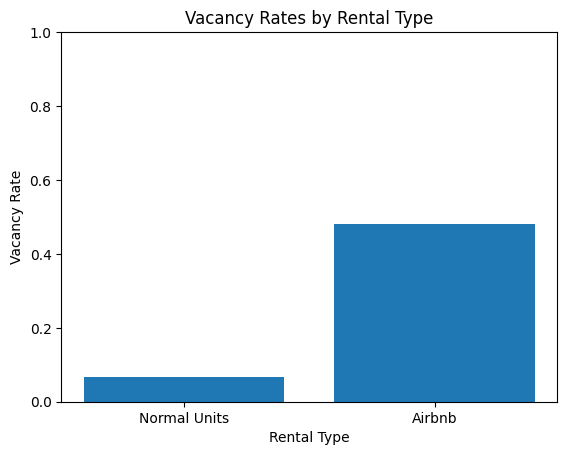

In [101]:
# bar plot comparing the vacancy rates 
plt.bar(df3["Type"],df3["Vacancy Rate"])
plt.ylim(0,1)
plt.xlabel("Rental Type")
plt.ylabel("Vacancy Rate")
plt.title("Vacancy Rates by Rental Type")
plt.savefig("Images/vacancy_rates_by_type.png")
plt.show()

In [98]:
# Finding the mean of the '% available' column grouped by neighborhood
vacancy_rates = df.groupby(["neighbourhood"])["% available"].mean()
vacancy_rates = pd.DataFrame(vacancy_rates)
vacancy_rates

,% available
neighbourhood,
Bayview,0.496323
Bernal Heights,0.390695
Castro/Upper Market,0.471953
Chinatown,0.554214
Crocker Amazon,0.607002
Diamond Heights,0.513804
Downtown/Civic Center,0.386311
Excelsior,0.502586
Financial District,0.449200


In [99]:
# resetting the index for plotting
vacancy_rates = vacancy_rates.reset_index()

C:\Users\simon\AppData\Local\Temp\ipykernel_19036\348382085.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=90, fontsize=20)
C:\Users\simon\AppData\Local\Temp\ipykernel_19036\348382085.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks, rotation=0, fontsize=15)


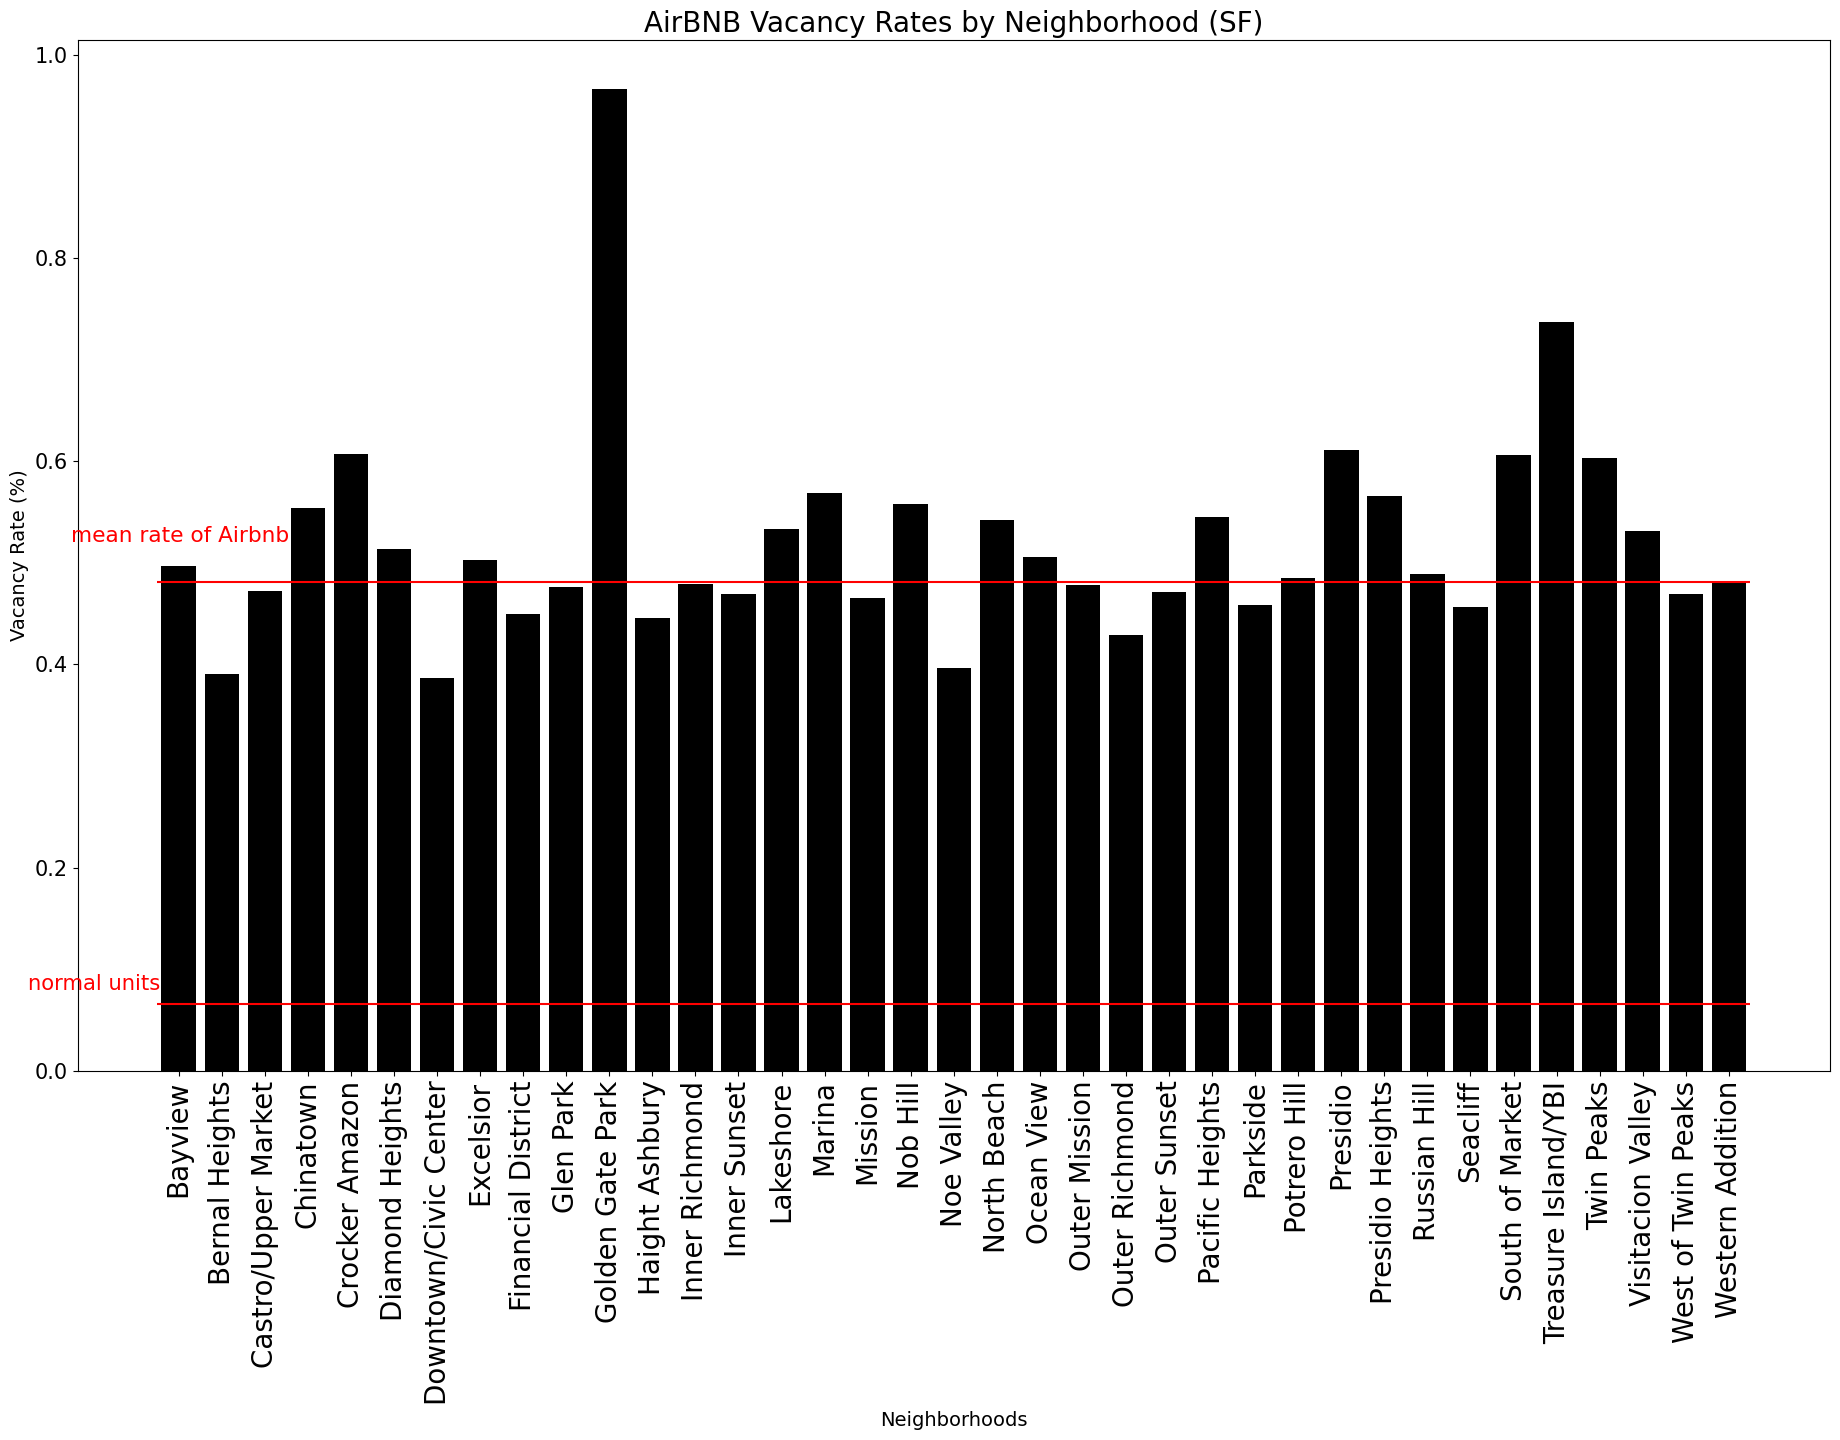

In [102]:
# setting the size for the bar plot
fig = figure(figsize=(10, 8), dpi=100)
fig.set_size_inches(18.5, 14.5)

# creating the bar plot 
plt.bar(vacancy_rates["neighbourhood"],vacancy_rates["% available"], color = "black")
ax = plt.gca()
plt.title("AirBNB Vacancy Rates by Neighborhood (SF)", fontsize = 20)
plt.xlabel("Neighborhoods", fontsize = 14)
plt.ylabel("Vacancy Rate (%)", fontsize = 14)
x_ticks = vacancy_rates["neighbourhood"]
y_ticks = ["0.0","0.2","0.4","0.6","0.8","1.0"]
plt.xticks(rotation=90)
#plt.grid(which="major")
ax.set_xticklabels(x_ticks, rotation=90, fontsize=20)
ax.set_yticklabels(y_ticks, rotation=0, fontsize=15)
plt.hlines(average_vacancy_rate, -0.5, 36.5, colors="red")
plt.tight_layout()
plt.hlines(normal_rate, -0.5, 36.5, colors="red")
plt.text(-2.5,.52,"mean rate of Airbnb", fontsize = 15.6, color = "red" )
plt.text(-3.5,.08,"normal units", fontsize = 15.2, color = "red")
plt.savefig("Images/sf_neighborhoods.png")
plt.show()